In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [2]:
cd uninet_27_04_2025

/content/drive/MyDrive/uninet_27_04_2025


In [ ]:
!git clone https://github.com/pangdatangtt/UniNet.git

Cloning into 'UniNet'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 110 (delta 36), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 6.52 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [3]:
cd UniNet

/content/drive/MyDrive/uninet_27_04_2025/UniNet


In [ ]:
!cp -r /content/drive/MyDrive/STPM_12_04_2024/STPM_anomaly_detection/mvtec_anomaly_detection/ /content/drive/MyDrive/uninet_27_04_2025/UniNet/

In [ ]:
ls -al

total 127
drwx------ 2 root root  4096 Apr 26 20:45 ckpts/
-rw------- 1 root root 30537 Apr 26 20:45 datasets.py
-rw------- 1 root root 18941 Apr 26 20:45 eval.py
drwx------ 2 root root  4096 Apr 26 20:45 figures/
drwx------ 8 root root  4096 Apr 26 20:45 .git/
-rw------- 1 root root  1065 Apr 26 20:45 LICENSE
-rw------- 1 root root 13907 Apr 26 20:45 main.py
drwx------ 3 root root  4096 Apr 26 20:47 mvtec_anomaly_detection/
-rw------- 1 root root  6310 Apr 26 20:45 polyp_dataset.py
-rw------- 1 root root  4420 Apr 26 20:45 README.md
-rw------- 1 root root  3186 Apr 26 20:45 test.py
-rw------- 1 root root  4094 Apr 26 20:45 train_multiclass.py
-rw------- 1 root root  3579 Apr 26 20:45 train_polypseg.py
-rw------- 1 root root  6045 Apr 26 20:45 train_unsupervisedAD.py
-rw------- 1 root root  3476 Apr 26 20:45 train_vad.py
drwx------ 2 root root  4096 Apr 26 20:45 UniNet_lib/
-rw------- 1 root root  3742 Apr 26 20:45 utils.py
-rw------- 1 root root  7151 Apr 26 20:45 video_dataset.py


In [ ]:
# %load datasets.py
%%writefile datasets.py

from torchvision import transforms
from PIL import Image
import os
import torch
import glob
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST, ImageFolder
import numpy as np
# from noise import Simplex_CLASS
import cv2
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from video_dataset import Video_DataLoader
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="importlib._bootstrap")


BTAD_PATH = os.path.abspath(os.path.join("D:\ws/btad"))

UnsupervisedAD = ['MVTec AD']
SupervisedAD = ["Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB", "VAD"]

# mvtec_list = ['carpet', 'bottle', 'hazelnut', 'leather', 'cable', 'capsule', 'grid', 'pill',
#               'transistor', 'metal_nut', 'screw', 'toothbrush', 'zipper', 'tile', 'wood']
mvtec_list = ['wood']

mvtec3d_list = ["bagel", "carrot", "cookie", "dowel", "foam",
                "peach", "potato", "tire", "rope", "cable_gland"]
# mvtec3d_list = ["carrot"]

btad_list = ["01", "02", "03"]
# btad_list = ['02']

visa_list = ['candle', 'capsules', 'cashew', 'chewinggum', 'fryum', 'macaroni1',
             'macaroni2', 'pcb1', 'pcb2', 'pcb3', 'pcb4', 'pipe_fryum']


def loading_dataset(c, dataset_name):
    train_dataloader, test_dataloader = None, None

    if dataset_name == 'MVTec 3D-AD' and c.setting == 'oc':
        train_dataloader = get_data_loader('train', c)
        test_dataloader = get_data_loader('test', c)
    elif dataset_name == 'BTAD' and c.setting == 'oc':
        train_data = BTADDataset(c, is_train=True)
        test_data = BTADDataset(c, is_train=False)
        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True,
                                                       pin_memory=True)
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)
    elif dataset_name == 'MVTec AD' and c.setting == 'oc':
        # train_path = './mvtec/' + c._class_ + '/train'
        # data_transform, gt_transform = get_data_transforms(c.image_size, c.image_size)
        # train_data = NoiseMVTecDataset(root=train_path, transform=data_transform)
        # train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True)
        train_data = MVTecDataset(c, is_train=True)
        test_data = MVTecDataset(c, is_train=False)
        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True,
                                                       pin_memory=True)
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

    elif dataset_name in ['MVTec AD', 'BTAD', 'MVTec 3D-AD', "VisA"] and c.setting == 'mc':
        data_transform, gt_transform = get_data_transforms(256, 256)
        train_data_list = []
        test_data_list = []

        lr = {}
        if dataset_name == "VisA":
            dataset_name = "visa"
            class_list = visa_list
            # lr = {"lr_s": 5e-3, "lr_t": 1e-6}
        elif dataset_name == 'MVTec AD':
            dataset_name = 'mvtec'
            class_list = mvtec_list
            lr = {"lr_s": 2e-3, "lr_t": 5e-5}
        elif dataset_name == 'BTAD':
            dataset_name = 'btad'
            class_list = btad_list
        else:
            dataset_name = 'mvtec_3d'
            class_list = mvtec3d_list

        for i, item in enumerate(class_list):
            train_path = 'data/{}/'.format(dataset_name) + item + '/train'
            test_path = 'data/{}/'.format(dataset_name) + item

            train_data = ImageFolder(root=train_path, transform=data_transform)
            train_data.classes = item
            train_data.class_to_idx = {item: i}
            train_data.samples = [(sample[0], i) for sample in train_data.samples]

            test_data = MultiMVTecDataset(root=test_path, transform=data_transform,
                                          gt_transform=gt_transform, phase="test")
            train_data_list.append(train_data)
            test_data_list.append(test_data)

        train_data = ConcatDataset(train_data_list)
        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True,
                                                       num_workers=1, drop_last=True)
        test_dataloader_list = [
            torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=1)
            for test_data in test_data_list]

        return train_dataloader, test_dataloader_list, class_list, lr

    elif dataset_name in ["APTOS", "ISIC2018", "OCT2017"]:
        data_transform, gt_transform = get_data_transforms(c.image_size, 224) \
        if dataset_name == 'ISIC2018' else get_data_transforms(c.image_size, c.image_size)

        train_path = 'data/{}'.format(dataset_name)
        test_path = 'data/{}'.format(dataset_name)

        train_data = MedicalDataset(root=train_path, transform=data_transform, phase="train")
        test_data = MedicalDataset(root=test_path, transform=data_transform, phase="test")
        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True,
                                                       drop_last=False)
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

    elif dataset_name in ["ped2"]:
        h, w = c.image_size, c.image_size
        time_step = 0
        train_folder = 'video/ped2/training/frames'
        # Loading dataset
        train_dataset = Video_DataLoader(train_folder, transforms.Compose([transforms.ToTensor(), ]),
                                         resize_height=h, resize_width=w, time_step=time_step, c=3)

        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=c.batch_size, shuffle=True,
                                                       drop_last=True, pin_memory=True)
        test_folder = 'video/ped2/testing/frames'

        # Loading dataset
        test_dataset = Video_DataLoader(test_folder, transforms.Compose([transforms.ToTensor(), ]),
                                        resize_height=h, resize_width=w, time_step=time_step, c=3)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                                      shuffle=False, drop_last=False)

    elif dataset_name in ["Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB"]:
        from polyp_dataset import get_loader, test_dataset
        train_path = '../medical_segmentation/datasets/{}/train'.format(dataset_name)
        # train_path = '../medical_segmentation/datasets/Cross/train'

        image_root = '{}/images/'.format(train_path)
        gt_root = '{}/masks/'.format(train_path)
        train_dataloader = get_loader(image_root, gt_root, batchsize=c.batch_size,
                                      trainsize=c.image_size, augmentation=True)

        test_path = '../medical_segmentation/datasets/{}/test'.format(dataset_name)
        # test_path = '../medical_segmentation/datasets/Cross/test'

        image_root = '{}/images/'.format(test_path)
        gt_root = '{}/masks/'.format(test_path)
        test_dataloader = test_dataset(image_root, gt_root, c.image_size)

        num1 = len(os.listdir(gt_root))

        return train_dataloader, test_dataloader, num1

    elif dataset_name in ['vad']:
        train_data = VADDataset(c, is_train=True)
        test_data = VADDataset(c, is_train=False)
        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=c.batch_size, shuffle=True,
                                                       pin_memory=True)
        test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

    return train_dataloader, test_dataloader


class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, c, is_train=True, dataset='mvtec'):
        self.dataset_path = '/content/drive/MyDrive/uninet_27_04_2025/UniNet/data/' + dataset
        self.class_name = c._class_
        self.is_train = is_train
        # self.is_vis = c.is_vis
        self.input_size = (c.image_size, c.image_size)
        self.aug = False
        phase = 'train' if self.is_train else 'test'
        self.img_dir = os.path.join(self.dataset_path, self.class_name, phase)
        self.gt_dir = os.path.join(self.dataset_path, self.class_name, 'ground_truth')
        # load dataset
        self.x, self.y, self.mask, _ = self.load_dataset()
        # set transforms
        if is_train:
                self.transform_x = T.Compose([
                    T.Resize(self.input_size, InterpolationMode.LANCZOS),
                    T.ToTensor()])
        # test:
        else:
            self.transform_x = T.Compose([
                T.Resize(self.input_size, InterpolationMode.LANCZOS),
                T.ToTensor()])
        # mask
        self.transform_mask = T.Compose([
            T.Resize(self.input_size, InterpolationMode.NEAREST),
            T.ToTensor()])

        self.normalize = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        # x = Image.open(x).convert('RGB')
        # if os.path.isfile(x):
        x = Image.open(x)

        if self.class_name in ['zipper', 'screw', 'grid']:  # handle greyscale classes
            x = np.expand_dims(np.array(x), axis=2)
            x = np.concatenate([x, x, x], axis=2)

            x = Image.fromarray(x.astype('uint8')).convert('RGB')
        #
        x = self.normalize(self.transform_x(x))
        #
        if y == 0:
            mask = torch.zeros([1, *self.input_size])
        else:
            mask = Image.open(mask)
            mask = self.transform_mask(mask)

        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset(self):

        img_tot_paths = list()
        gt_tot_paths = list()
        tot_labels = list()
        tot_types = list()

        defect_types = os.listdir(self.img_dir)

        for defect_type in defect_types:
            # if self.is_vis and defect_type == "good":
                # continue
            if defect_type == 'good':
                img_paths = glob.glob(os.path.join(self.img_dir, defect_type) + "/*")
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend([None] * len(img_paths))
                tot_labels.extend([0] * len(img_paths))
            else:
                img_paths = glob.glob(os.path.join(self.img_dir, defect_type) + "/*")
                gt_paths = glob.glob(os.path.join(self.gt_dir, defect_type) + "/*")
                img_paths.sort()
                gt_paths.sort()
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend(gt_paths)
                tot_labels.extend([1] * len(img_paths))

        assert len(img_tot_paths) == len(tot_labels), "Something wrong with test and ground truth pair!"

        return img_tot_paths, tot_labels, gt_tot_paths, tot_types


class VADDataset(torch.utils.data.Dataset):
    def __init__(self, c, is_train=True):
        self.dataset_path = 'data/vad'
        self.is_train = is_train
        self.is_vis = False
        self.input_size = (c.image_size, c.image_size)
        self.aug = False
        phase = 'train' if self.is_train else 'test'
        self.img_dir = os.path.join(self.dataset_path, phase)
        # load dataset
        self.x, self.y = self.load_dataset()
        # set transforms
        if is_train:
            self.transform_x = T.Compose([
                T.Resize(self.input_size, InterpolationMode.LANCZOS),
                T.ToTensor()])
        # test:
        else:
            self.transform_x = T.Compose([
                T.Resize(self.input_size, InterpolationMode.LANCZOS),
                T.ToTensor()])

        self.normalize = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        # x = Image.open(x).convert('RGB')
        # if os.path.isfile(x):
        x = Image.open(x)

        # x = np.expand_dims(np.array(x), axis=2)
        # x = np.concatenate([x, x, x], axis=2)

        # x = Image.fromarray(x.astype('uint8')).convert('RGB')
        x = self.normalize(self.transform_x(x))

        return x, y

    def __len__(self):
        return len(self.x)

    def load_dataset(self):

        img_tot_paths = list()
        tot_labels = list()
        unseen_labels = list()

        defect_types = os.listdir(self.img_dir)

        for defect_type in defect_types:
            if self.is_vis and defect_type == "good":
                continue
            if defect_type == 'good':
                img_paths = glob.glob(os.path.join(self.img_dir, defect_type) + "/*.png")
                img_tot_paths.extend(img_paths)
                tot_labels.extend([0] * len(img_paths))
            else:
                if defect_type != 'bad_unseen_defects':
                    img_paths = glob.glob(os.path.join(self.img_dir, defect_type) + "/*.png")
                    img_paths.sort()
                    img_tot_paths.extend(img_paths)
                    tot_labels.extend([1] * len(img_paths))
                else:
                    img_paths_ = glob.glob(os.path.join(self.img_dir, defect_type) + "/*.png")
                    img_paths_.sort()
                    img_tot_paths.extend(img_paths_)
                    tot_labels.extend([2] * len(img_paths_))

        assert len(img_tot_paths) == len(tot_labels), "Something wrong with test and ground truth pair!"

        return img_tot_paths, tot_labels,


class BTADDataset(torch.utils.data.Dataset):
    def __init__(self, c, is_train=True):
        assert c._class_ in btad_list, 'class_name: {}, should be in {}'. \
            format(c._class_, btad_list)
        self.dataset_path = BTAD_PATH
        self.class_name = c._class_
        self.is_train = is_train
        self.input_size = (c.image_size, c.image_size)
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        # set transforms
        if is_train:
            self.transform_x = T.Compose([
                T.Resize(self.input_size, InterpolationMode.LANCZOS),
                T.ToTensor()])
        # test:
        else:
            self.transform_x = T.Compose([
                T.Resize(self.input_size, InterpolationMode.LANCZOS),
                T.ToTensor()])
        # mask
        self.transform_mask = T.Compose([
            T.Resize(self.input_size, InterpolationMode.NEAREST),
            T.ToTensor()])

        self.normalize = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        # x = Image.open(x).convert('RGB')
        x = Image.open(x)
        x = self.normalize(self.transform_x(x))
        #
        if y == 0:
            mask = torch.zeros([1, *self.input_size])
        else:
            mask = Image.open(mask)
            mask = self.transform_mask(mask)

        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []

        img_dir = os.path.join(self.dataset_path, self.class_name, phase)  # data/Mvtec/bottle/train
        gt_dir = os.path.join(self.dataset_path, self.class_name, 'ground_truth')  # data/Mvtec/bottle/gt

        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types:
            # load images
            img_type_dir = os.path.join(img_dir, img_type)  # data/Mvtec/bottle/train/good(ok)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir) if
                                     f.endswith(('.png', '.jpg', '.bmp'))])  # data/Mvtec/bottle/train/good/000.png...
            x.extend(img_fpath_list)

            # load gt labels
            if img_type == 'ok':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)  # # data/Mvtec/bottle/train/broken_large...
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in
                                  img_fpath_list]  # ['000', '001', ...]
                pix = '.bmp' if self.class_name == '03' else '.png'
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + pix)
                                 for img_fname in img_fname_list]  # data/Mvtec/bottle/train/broken_large/000_maks.png
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        return list(x), list(y), list(mask)


class MultiMVTecDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, gt_transform, phase):
        if phase == 'train':
            self.img_path = os.path.join(root, 'train')
        else:
            self.img_path = os.path.join(root, 'test')
            self.gt_path = os.path.join(root, 'ground_truth')
        self.transform = transform
        self.gt_transform = gt_transform
        # load dataset
        self.img_paths, self.gt_paths, self.labels, self.types = self.load_dataset()  # self.labels => good : 0, anomaly : 1

    def load_dataset(self):

        img_tot_paths = []
        gt_tot_paths = []
        tot_labels = []
        tot_types = []

        defect_types = os.listdir(self.img_path)

        for defect_type in defect_types:
            if defect_type == 'good' or defect_type == 'ok':
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.png") + \
                            glob.glob(os.path.join(self.img_path, defect_type) + "/*.JPG")
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend([0] * len(img_paths))
                tot_labels.extend([0] * len(img_paths))
                tot_types.extend(['good'] * len(img_paths))
            else:
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*.png") + \
                            glob.glob(os.path.join(self.img_path, defect_type) + "/*.JPG")
                gt_paths = glob.glob(os.path.join(self.gt_path, defect_type) + "/*.png")
                img_paths.sort()
                gt_paths.sort()
                img_tot_paths.extend(img_paths)
                gt_tot_paths.extend(gt_paths)
                tot_labels.extend([1] * len(img_paths))
                tot_types.extend([defect_type] * len(img_paths))

        assert len(img_tot_paths) == len(gt_tot_paths), "Something wrong with test and ground truth pair!"

        return img_tot_paths, gt_tot_paths, tot_labels, tot_types

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, gt, label, img_type = self.img_paths[idx], self.gt_paths[idx], self.labels[idx], self.types[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        if gt == 0:
            gt = torch.zeros([1, img.size()[-2], img.size()[-2]])
        else:
            gt = Image.open(gt)
            gt = self.gt_transform(gt)

        assert img.size()[1:] == gt.size()[1:], "image.size != gt.size !!!"

        return img, gt, label, img_path


# def get_data_transforms(size, isize):
#     data_transforms = transforms.Compose([Normalize(), \
#                                           ToTensor()])
#     gt_transforms = transforms.Compose([
#         transforms.Resize((size, size)),
#         transforms.ToTensor()])
#     return data_transforms, gt_transforms
def get_data_transforms(size, isize, mean_train=None, std_train=None):
    mean_train = [0.485, 0.456, 0.406] if mean_train is None else mean_train
    std_train = [0.229, 0.224, 0.225] if std_train is None else std_train
    data_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.CenterCrop(isize),
        transforms.Normalize(mean=mean_train,
                             std=std_train)])
    gt_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.CenterCrop(isize),
        transforms.ToTensor()])
    return data_transforms, gt_transforms


class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, phase):
        if phase == 'train':
            self.img_path = os.path.join(root, 'train')
        else:
            self.img_path = os.path.join(root, 'test')
        self.transform = transform
        self.phase = phase
        # load dataset
        self.img_paths, self.labels = self.load_dataset()  # self.labels => good : 0, anomaly : 1
        self.num = 0

    def load_dataset(self):

        img_tot_paths = []
        tot_labels = []

        defect_types = os.listdir(self.img_path)

        for defect_type in defect_types:
            if defect_type == 'NORMAL':
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*")
                img_tot_paths.extend(img_paths)
                tot_labels.extend([0] * len(img_paths))
            else:
                if self.phase == 'train':
                    continue
                img_paths = glob.glob(os.path.join(self.img_path, defect_type) + "/*")
                img_tot_paths.extend(img_paths)
                tot_labels.extend([1] * len(img_paths))

        return img_tot_paths, tot_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx], self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        return img, label, img_path


"--------------------------------------------------3D_dataset----------------------------------------------------------"

from utils import utils_3D

DATASETS_PATH = os.path.abspath(os.path.join("D:\ws\THF\data\Mvtec_3d"))


class MVTec_3D(torch.utils.data.Dataset):
    def __init__(self, split, class_name, img_size, centercrop):
        self.IMAGENET_MEAN = [0.485, 0.456, 0.406]
        self.IMAGENET_STD = [0.229, 0.224, 0.225]
        self.cls = class_name
        self.size = img_size
        self.centercrop = centercrop
        self.img_path = os.path.join(DATASETS_PATH, self.cls, split)
        self.rgb_transform = transforms.Compose(
            [
                transforms.CenterCrop((self.centercrop, self.centercrop)),
                transforms.Resize(self.size, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)])


class MVTec_3D_Train(MVTec_3D):
    def __init__(self, class_name, img_size, centercrop):
        super().__init__(split="train", class_name=class_name, img_size=img_size, centercrop=centercrop)
        self.img_paths, self.labels = self.load_dataset()  # self.labels => good : 0, anomaly : 1

    def load_dataset(self):
        img_tot_paths = []
        tot_labels = []
        rgb_paths = glob.glob(os.path.join(self.img_path, 'good', 'rgb') + "/*.png")
        tiff_paths = glob.glob(os.path.join(self.img_path, 'good', 'xyz') + "/*.tiff")
        rgb_paths.sort()
        tiff_paths.sort()
        sample_paths = list(zip(rgb_paths, tiff_paths))
        img_tot_paths.extend(sample_paths)
        tot_labels.extend([0] * len(sample_paths))
        return img_tot_paths, tot_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx], self.labels[idx]
        rgb_path = img_path[0]
        tiff_path = img_path[1]
        img = Image.open(rgb_path).convert('RGB')

        img = self.rgb_transform(img)
        organized_pc = utils_3D.read_tiff_organized_pc(tiff_path)
        depth_map_3channel = np.repeat(utils_3D.organized_pc_to_depth_map(organized_pc)[:, :, np.newaxis], 3, axis=2)
        resized_depth_map_3channel = utils_3D.resize_organized_pc(depth_map_3channel, self.size)
        resized_organized_pc = utils_3D.resize_organized_pc(organized_pc, self.size)
        return (img, resized_organized_pc, resized_depth_map_3channel), label


class MVTec_3D_Test(MVTec_3D):
    def __init__(self, class_name, img_size, centercrop):
        super().__init__(split="test", class_name=class_name, img_size=img_size, centercrop=centercrop)
        self.gt_transform = transforms.Compose([
            transforms.CenterCrop((self.centercrop, self.centercrop)),
            transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor()])
        self.img_paths, self.gt_paths, self.labels = self.load_dataset()  # self.labels => good : 0, anomaly : 1

    def load_dataset(self):
        img_tot_paths = []
        gt_tot_paths = []
        tot_labels = []
        defect_types = os.listdir(self.img_path)

        for defect_type in defect_types:
            if defect_type == 'good':
                rgb_paths = glob.glob(os.path.join(self.img_path, defect_type, 'rgb') + "/*.png")
                tiff_paths = glob.glob(os.path.join(self.img_path, defect_type, 'xyz') + "/*.tiff")
                rgb_paths.sort()
                tiff_paths.sort()
                sample_paths = list(zip(rgb_paths, tiff_paths))
                img_tot_paths.extend(sample_paths)
                gt_tot_paths.extend([0] * len(sample_paths))
                tot_labels.extend([0] * len(sample_paths))
            else:
                rgb_paths = glob.glob(os.path.join(self.img_path, defect_type, 'rgb') + "/*.png")
                tiff_paths = glob.glob(os.path.join(self.img_path, defect_type, 'xyz') + "/*.tiff")
                gt_paths = glob.glob(os.path.join(self.img_path, defect_type, 'gt') + "/*.png")
                rgb_paths.sort()
                tiff_paths.sort()
                gt_paths.sort()
                sample_paths = list(zip(rgb_paths, tiff_paths))

                img_tot_paths.extend(sample_paths)
                gt_tot_paths.extend(gt_paths)
                tot_labels.extend([1] * len(sample_paths))

        assert len(img_tot_paths) == len(gt_tot_paths), "Something wrong with test and ground truth pair!"

        return img_tot_paths, gt_tot_paths, tot_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, gt, label = self.img_paths[idx], self.gt_paths[idx], self.labels[idx]
        rgb_path = img_path[0]
        tiff_path = img_path[1]
        img_original = Image.open(rgb_path).convert('RGB')
        img = self.rgb_transform(img_original)

        organized_pc = utils_3D.read_tiff_organized_pc(tiff_path)
        depth_map_3channel = np.repeat(utils_3D.organized_pc_to_depth_map(organized_pc)[:, :, np.newaxis], 3, axis=2)
        resized_depth_map_3channel = utils_3D.resize_organized_pc(depth_map_3channel, self.size)
        resized_organized_pc = utils_3D.resize_organized_pc(organized_pc, self.size)

        if gt == 0:
            gt = torch.zeros(
                [1, resized_depth_map_3channel.size()[-2], resized_depth_map_3channel.size()[-2]])
        else:
            gt = Image.open(gt).convert('L')
            gt = self.gt_transform(gt)
            gt = torch.where(gt > 0.5, 1., .0)

        # if self.is_rd:
        #     return (img, resized_organized_pc, resized_depth_map_3channel), label, gt

        return (img, resized_organized_pc, resized_depth_map_3channel), label, gt[:1]


def get_data_loader(split, c):
    is_rd = c.is_rd if hasattr(c, "is_rd") else False
    if split in ['train']:
        dataset = MVTec_3D_Train(class_name=c._class_, img_size=c.image_size, centercrop=c.center_crop)
    elif split in ['test']:
        dataset = MVTec_3D_Test(class_name=c._class_, img_size=c.image_size, centercrop=c.center_crop,
                                is_vis=c.is_vis, is_rd=is_rd)

    is_train = split in ['train']
    batch_size = c.batch_size if is_train else 1
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train,
                                              drop_last=is_train, pin_memory=True)
    return data_loader


def preprocess_for_3d(c):
    # crop off the background
    if c._class_ in ['potato']:
        c.center_crop = 384
    elif c._class_ in ['dowel', 'cable_gland']:
        c.center_crop = 256
    elif c._class_ in ['foam']:
        c.center_crop = 700
    else:
        c.center_crop = 900 if c._class_ == 'rope' else 512

    return c


class ToTensor(object):
    def __call__(self, image):
        try:
            image = torch.from_numpy(image.transpose(2, 0, 1))
        except:
            print('Invalid_transpose, please make sure images have shape (H, W, C) before transposing')
        if not isinstance(image, torch.FloatTensor):
            image = image.float()
        return image


class Normalize(object):
    """
    Only normalize images
    """

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, image):
        image = (image - self.mean) / self.std
        return image

Overwriting datasets.py


In [24]:
# %load main.py
%%writefile main.py

import numpy as np
import os

from train_unsupervisedAD import train
from datasets import preprocess_for_3d, UnsupervisedAD, SupervisedAD, \
    mvtec_list, btad_list, mvtec3d_list, visa_list
import argparse
from utils import setup_seed, get_logger
from test import test


def parsing_args():
    parser = argparse.ArgumentParser(description='UniNet')

    parser.add_argument('--domain', default='industrial', type=str,
                        choices=['industrial', 'medical', 'video', 'natural'], help="choose experimental domain.")
    parser.add_argument('--setting', default='mc', type=str, choices=['oc', 'mc', 'cd'],
                        help="choose experimental settings, including one-class, multi-class, cross-dataset.")
    parser.add_argument('--dataset', default='MVTec AD', type=str,
                        choices=['MVTec AD', 'BTAD', 'MVTec 3D-AD', "VisA", "VAD", "APTOS", "ISIC2018", "OCT2017",
                                 "Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB", "Ped2"],
                        help="choose experimental dataset.")
    parser.add_argument('--epochs', default=100, type=int, help="epochs.")
    parser.add_argument('--batch_size', default=8, type=int, help="batch sizes.")
    parser.add_argument('--image_size', default=256, type=int, help="image size.")
    parser.add_argument('--center_crop', default=256, type=int, help="crop image size.")
    parser.add_argument('--lr_s', default=5e-3, type=float, help="lr for student.")  # 5e-3
    parser.add_argument('--lr_t', default=1e-6, type=float, help="lr for teacher.")  # 1e-6
    parser.add_argument('--T', default=2, type=float, help="temperature for contrastive learning.")

    parser.add_argument('--weighted_decision_mechanism', action='store_true', default=True,
                        help='whether to employ weight-guided similarity to calculate anomaly map.')
    parser.add_argument('--default', default=0.3, type=float, help='the default value of weights.')
    parser.add_argument('--alpha', default=0.01, type=float, help='hyperparameters for weights.')
    parser.add_argument('--beta', default=0.00003, type=float, help='hyperparameters for weights.')

    parser.add_argument("--train_and_test_all", action='store_true', default=True,
                        help="for medical domains.")
    parser.add_argument("--is_saved", action='store_true', default=True, help="whether to save model weights.")
    parser.add_argument('--save_dir', type=str, default='./saved_results')
    parser.add_argument('--load_ckpts', action='store_true', default=True, help="loading ckpts for testing")

    args = parser.parse_args()

    # for k, v in vars(args).items():
    #     setattr(c, k, v)

    return args


if __name__ == '__main__':
    setup_seed(1203)
    c = parsing_args()
    if not c.weighted_decision_mechanism:
        c.default = c.alpha = c.beta = c.gamma = "w/o"

    domain = c.domain
    dataset_name = c.dataset
    logger = get_logger(dataset_name, os.path.join(c.save_dir, dataset_name))
    # print_fn = logger.info

    dataset = None
    if dataset_name in UnsupervisedAD:
        if dataset_name == 'MVTec AD':
            dataset = mvtec_list
        elif dataset_name == "MVTec 3D-AD":
            dataset = mvtec3d_list
        elif dataset_name == 'BTAD':
            dataset = btad_list
        elif dataset_name == 'VisA':
            dataset = visa_list
        elif dataset_name in ["APTOS", "ISIC2018", "OCT2017", "ped2"]:
            dataset = [dataset_name]

    elif dataset_name in SupervisedAD:
        dataset = [dataset_name]

    else:
        raise KeyError(f"Dataset '{dataset_name}' can not be found.")

    from tabulate import tabulate

    results = {}
    table_ls = []

    # ---------------------------------------------------------------------------------------------------------
    # --------------------------------------unsupervised industrial AD-----------------------------------------
    # ---------------------------------------------------------------------------------------------------------
    if dataset_name in UnsupervisedAD and domain == 'industrial':
        image_auroc_list = []
        pixel_auroc_list = []
        pixel_aupro_list = []

        # -----------------------------train-------------------------------------
        if not c.load_ckpts:
            for idx, i in enumerate(dataset):
                c._class_ = i
                if dataset_name == 'MVTec 3D-AD':
                    c = preprocess_for_3d(c)

                args_dict = vars(c)
                args_info = f"class:{i}, " if c.setting == 'oc' else f""
                for key, value in args_dict.items():
                    if key in ['_class_']:
                        continue
                    args_info += ", ".join([f"{key}:{value}, "])

                if c.setting == 'oc':
                    print('training on {} dataset (separate-class)'.format(dataset_name)) if idx == 0 else None
                    print(args_info)
                    train(c)
                elif c.setting == 'mc':
                    print('training on {} dataset (multiclass)'.format(dataset_name)) if idx == 0 else None
                    print(args_info)
                    from train_multiclass import train_mc
                    train_mc(c)
                    break
                else:
                    pass
                print()
            print("training over!")

        # -----------------------------test-------------------------------------
        if c.setting == 'oc':
            for idx, i in enumerate(dataset):
                print('testing on {} dataset (separate-class)'.format(dataset_name)) if idx == 0 else None
                c._class_ = i
                print(f"testing class:{i}")
                auroc_sp, auroc_px, aupro_px = test(c, 'BEST_P_PRO')
                print('')
                table_ls.append(['{}'.format(i), str(np.round(auroc_sp, decimals=1)),
                                 str(np.round(auroc_px, decimals=1)),
                                 str(np.round(aupro_px, decimals=1))])
                image_auroc_list.append(auroc_sp)
                pixel_auroc_list.append(auroc_px)
                pixel_aupro_list.append(aupro_px)
                results = tabulate(table_ls, headers=['object', 'image_auroc', 'pixel_auroc', 'pixel_aupro'],
                                   tablefmt="pipe")
            table_ls.append(['mean', str(np.round(np.mean(image_auroc_list), decimals=2)),
                             str(np.round(np.mean(pixel_auroc_list), decimals=2)),
                             str(np.round(np.mean(pixel_aupro_list), decimals=2))])
            results = tabulate(table_ls, headers=['object', 'image_auroc', 'pixel_auroc', 'pixel_aupro'],
                               tablefmt="pipe")
            print(results)

        elif c.setting == 'mc':
            print('testing on {} dataset (multiclass)'.format(dataset_name))

            c._class_ = ''
            auroc_list, acc_list, f1_list, class_list = test(c, 'BEST_I_ROC')
            print('')

            for i, x, y, z in zip(class_list, auroc_list, acc_list, f1_list):
                table_ls.append(['{}'.format(i), str(np.round(x, decimals=1)),
                                 str(np.round(y, decimals=1)),
                                 str(np.round(z, decimals=1))])
                results = tabulate(table_ls, headers=['object', 'image_auroc', 'acc', 'f1'], tablefmt="pipe")
            table_ls.append(['mean', str(np.round(np.mean(auroc_list), decimals=2)),
                             str(np.round(np.mean(acc_list), decimals=2)),
                             str(np.round(np.mean(f1_list), decimals=2))])
            results = tabulate(table_ls, headers=['object', 'image_auroc', 'acc', 'f1'],
                               tablefmt="pipe")
            print(results)

    # ---------------------------------------------------------------------------------------------------
    # -------------------------------------unsupervised medical AD---------------------------------------
    # ---------------------------------------------------------------------------------------------------
    if dataset_name in UnsupervisedAD and domain == 'medical':
        if c.train_and_test_all:
            dataset = ["APTOS", "ISIC2018", "OCT2017"]

        image_auroc_list = []
        acc_list = []
        f1_list = []
        # -----------------------------train-------------------------------------
        if not c.load_ckpts:
            for idx, i in enumerate(dataset):
                c._class_ = i
                c.dataset = i

                args_dict = vars(c)
                args_info = ""
                for key, value in args_dict.items():
                    if key in ['_class_']:
                        continue
                    args_info += ", ".join([f"{key}:{value}, "])
                print('training on {} dataset'.format(i))
                print(args_info)
                train(c)
                print()
            print("training over!")

        # -----------------------------test-------------------------------------
        for idx, i in enumerate(dataset):
            print('testing on {} dataset'.format(i))
            c._class_ = i
            c.dataset = i
            auroc_sp, acc, f1 = test(c, 'BEST_I_ROC')
            print('')
            table_ls.append(['{}'.format(i), str(np.round(auroc_sp, decimals=1)),
                             str(np.round(acc, decimals=1)),
                             str(np.round(f1, decimals=1))])
            image_auroc_list.append(auroc_sp)
            acc_list.append(acc)
            f1_list.append(f1)
            results = tabulate(table_ls, headers=['object', 'image_auroc', 'acc', 'f1'], tablefmt="pipe")
        table_ls.append(['mean', str(np.round(np.mean(image_auroc_list), decimals=2)),
                         str(np.round(np.mean(acc_list), decimals=2)),
                         str(np.round(np.mean(f1_list), decimals=2))])
        results = tabulate(table_ls, headers=['object', 'image_auroc', 'acc', 'f1'], tablefmt="pipe")
        print(results)

    # ----------------------------------------------------------------------------------------------------------
    # --------------------------------supervised medical image segmentation-------------------------------------
    # ----------------------------------------------------------------------------------------------------------
    if dataset_name in SupervisedAD and domain == 'medical':
        if c.train_and_test_all:
            dataset = ["Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB"]

        mice_list = []
        miou_list = []
        # -----------------------------train-------------------------------------
        if not c.load_ckpts:
            for idx, i in enumerate(dataset):
                c._class_ = i
                c.dataset = i

                args_dict = vars(c)
                args_info = ""
                for key, value in args_dict.items():
                    if key in ['_class_']:
                        continue
                    args_info += ", ".join([f"{key}:{value}, "])
                print('training on {} dataset'.format(i))
                print(args_info)

                from train_polypseg import train_polyp
                train_polyp(c)
                print()
            print("training over!")

        # -----------------------------test-------------------------------------
        for idx, i in enumerate(dataset):
            print('testing on {} dataset'.format(i))
            c._class_ = i
            c.dataset = i

            mice, miou = test(c, 'BEST_DICE')

            table_ls.append(['{}'.format(i), str(np.round(mice, decimals=1)), str(np.round(miou, decimals=1))])
            mice_list.append(mice)
            miou_list.append(miou)
            results = tabulate(table_ls, headers=['object', 'mice', 'miou'], tablefmt="pipe")
        table_ls.append(['mean', str(np.round(np.mean(mice_list), decimals=2)),
                         str(np.round(np.mean(miou_list), decimals=2))])
        results = tabulate(table_ls, headers=['object', 'mice', 'miou'], tablefmt="pipe")
        print(results)

    # -----------------------------------------------------------------------------------------------
    # ------------------------------------unsupervised video AD--------------------------------------
    # -----------------------------------------------------------------------------------------------
    if dataset_name in SupervisedAD and domain == 'industrial':
        image_auroc_list = []
        acc_list = []
        f1_list = []
        for idx, i in enumerate(dataset):
            c._class_ = i

            args_dict = vars(c)
            args_info = ""
            for key, value in args_dict.items():
                if key in ['_class_']:
                    continue
                args_info += ", ".join([f"{key}:{value}, "])
            print('training on {} dataset'.format(dataset_name)) if idx == 0 else None
            print(args_info)

            from train_vad import train
            auroc_sp, acc, f1 = train(c)
            table_ls.append(['mean', str(np.round(auroc_sp, decimals=1)),
                             str(np.round(acc, decimals=1)),
                             str(np.round(f1, decimals=1))])
            image_auroc_list.append(auroc_sp)
            acc_list.append(acc)
            f1_list.append(f1)
            results = tabulate(table_ls, headers=['object', 'image_auroc', 'acc', 'f1'], tablefmt="pipe")
        print(results)


Overwriting main.py


In [33]:
# %load test.py
%%writefile test.py
import copy
import os

import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from sklearn.metrics import precision_recall_curve, roc_auc_score

from UniNet_lib.DFS import DomainRelated_Feature_Selection
from UniNet_lib.mechanism import weighted_decision_mechanism
from UniNet_lib.model import UniNet
from UniNet_lib.de_resnet import de_wide_resnet50_2
from eval import evaluation_indusAD, evaluation_batch, evaluation_mediAD, evaluation_polypseg
from UniNet_lib.resnet import wide_resnet50_2
from utils import load_weights, t2np, to_device
from torch.nn import functional as F
from datasets import loading_dataset

import cv2
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T





def test(c, suffix='BEST_P_PRO'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    dataset_name = c.dataset
    ckpt_path = None
    if c._class_ in [dataset_name]:
        ckpt_path = os.path.join("./ckpts", dataset_name)
    else:
        if c.setting == 'oc':
            ckpt_path = os.path.join("./ckpts", dataset_name, f"{c._class_}")
        elif c.setting == 'mc':
            ckpt_path = os.path.join("./ckpts", "{}".format(dataset_name), "multiclass")
        else:
            pass

    # --------------------------------------loading dataset------------------------------------------
    dataset_info = loading_dataset(c, dataset_name)
    test_dataloader = dataset_info[1]

    # model
    Source_teacher, bn = wide_resnet50_2(c, pretrained=True)
    Source_teacher.layer4 = None
    Source_teacher.fc = None
    student = de_wide_resnet50_2(pretrained=False)
    DFS = DomainRelated_Feature_Selection()
    [Source_teacher, bn, student, DFS] = to_device([Source_teacher, bn, student, DFS], device)
    Target_teacher = copy.deepcopy(Source_teacher)

    new_state = load_weights([Target_teacher, bn, student, DFS], ckpt_path, suffix)
    Target_teacher = new_state['tt']
    bn = new_state['bn']
    student = new_state['st']
    DFS = new_state['dfs']

    model = UniNet(c, Source_teacher.cuda().eval(), Target_teacher, bn, student, DFS)

    if c.domain == 'industrial':
        if c.setting == 'oc':
            auroc_px, auroc_sp, pro = evaluation_indusAD(c, model, test_dataloader, device)
            return auroc_sp, auroc_px, pro

        else:   # multiclass
            auroc_sp_list, ap_sp_list, f1_list = [], [], []
            # test_dataloader: List
            for test_loader in test_dataloader:
                auroc_sp, ap_sp, f1 = evaluation_batch(c, model, test_loader, device)
                auroc_sp_list.append(auroc_sp * 100)
                ap_sp_list.append(ap_sp * 100)
                f1_list.append(f1 * 100)
            return auroc_sp_list, ap_sp_list, f1_list, dataset_info[-2]

    if c.domain == 'medical':
        if dataset_name in ["APTOS", "ISIC2018", "OCT2017"]:
            auroc_sp, f1, acc = evaluation_mediAD(c, model, test_dataloader, device)
            return auroc_sp, acc, f1

        elif dataset_name in ["Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB"]:
            mice, miou = evaluation_polypseg(c, model, test_dataloader, dataset_info[-1])
            return mice, miou


Overwriting test.py


In [34]:
!python main.py --dataset "MVTec AD" --setting oc --save_dir "./results"

testing on MVTec AD dataset (separate-class)
testing class:wood
cuda
Loading weights from ./ckpts/MVTec AD/wood/BEST_P_PRO.pth
fps: 11.907680156162582 141
Sonuç kaydedildi: result_20250427_090037.png
Figure(1500x500)
Max Anomaly Score: 102.1549

| object   |   image_auroc |   pixel_auroc |   pixel_aupro |
|:---------|--------------:|--------------:|--------------:|
| wood     |           100 |          96.5 |          87.9 |
| mean     |           100 |          96.5 |          87.9 |


In [ ]:
rm -rf saved_results

In [ ]:
!pip show torch torchvision

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
---
Name: torchvision
Version: 0.21.0+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-p

## Test

cuda
Loading weights from ./ckpts/MVTec AD/wood/BEST_P_PRO.pth
fps: 12.649569309184406 141
Sonuç kaydedildi: result_20250427_091646.png


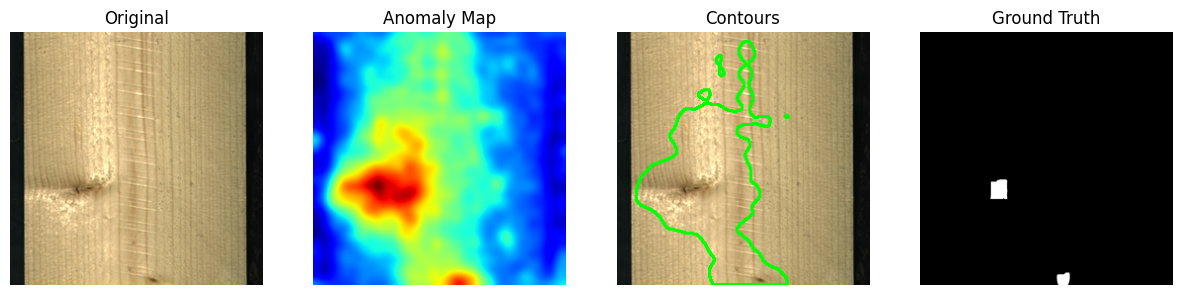

Max Anomaly Score: 2.1878
Image AUROC: 100.0
Pixel AUROC: 96.5
PRO Score: 87.9


In [37]:
import copy
import os

import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from sklearn.metrics import precision_recall_curve, roc_auc_score

from UniNet_lib.DFS import DomainRelated_Feature_Selection
from UniNet_lib.mechanism import weighted_decision_mechanism
from UniNet_lib.model import UniNet
from UniNet_lib.de_resnet import de_wide_resnet50_2
from eval import evaluation_indusAD, evaluation_batch, evaluation_mediAD, evaluation_polypseg
from UniNet_lib.resnet import wide_resnet50_2
from utils import load_weights, t2np, to_device
from torch.nn import functional as F
from datasets import loading_dataset

import cv2
import datetime
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T

# 1️⃣ Config Sınıfını Tanımla veya İçe Aktar
class Config:
    dataset = "MVTec AD"
    setting = "oc"
    domain = "industrial"
    _class_ = "wood"
    image_size = 256
    batch_size = 1
    T = 2
    weighted_decision_mechanism = True
    alpha = 0.01
    beta = 0.00003

c = Config()


def test_single_image_v2(c, model, device):
    import cv2
    import datetime
    from PIL import Image
    import matplotlib.pyplot as plt
    from torchvision import transforms as T
    from scipy.ndimage import gaussian_filter
    import numpy as np
    import torch
    from torch.nn import functional as F

    image_path = "/content/drive/MyDrive/uninet_27_04_2025/UniNet/data/mvtec/wood/test/defect/100000003.jpg"
    gt_path = "/content/drive/MyDrive/uninet_27_04_2025/UniNet/data/mvtec/wood/ground_truth/defect/100000003_mask.jpg"

    original_image = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((c.image_size, c.image_size)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(original_image).unsqueeze(0).to(device)

    model.train_or_eval(type='eval')
    n = model.n
    output_list = [list() for _ in range(n * 3)]

    with torch.no_grad():
        t_tf, de_features = model(input_tensor)

        for l, (t, s) in enumerate(zip(t_tf, de_features)):
            output = 1 - F.cosine_similarity(t, s)  # Cosine similarity farkı
            output_list[l].append(output)

        # Eval.py'deki weighted_decision_mechanism
        anomaly_score, anomaly_map = weighted_decision_mechanism(1, output_list, c.alpha, c.beta)
        anomaly_map = gaussian_filter(anomaly_map, sigma=4)
        anomaly_map = anomaly_map.squeeze()

    # Normalize ve Heatmap
    anomaly_map_norm = cv2.normalize(anomaly_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap = cv2.applyColorMap(anomaly_map_norm, cv2.COLORMAP_JET)

    # Kontur
    _, thresh = cv2.threshold(anomaly_map_norm, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    original_cv = np.array(original_image.resize((c.image_size, c.image_size)))
    original_cv = cv2.cvtColor(original_cv, cv2.COLOR_RGB2BGR)
    contour_image = cv2.drawContours(original_cv.copy(), contours, -1, (0, 255, 0), 2)

    # GT Mask
    if os.path.exists(gt_path):
        gt_mask = Image.open(gt_path).convert('L').resize((c.image_size, c.image_size))
    else:
        gt_mask = np.zeros_like(anomaly_map_norm)

    # Görselleştirme
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1); plt.title("Original"); plt.imshow(original_image.resize((c.image_size, c.image_size))); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title("Anomaly Map"); plt.imshow(anomaly_map, cmap='jet'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title("Contours"); plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title("Ground Truth"); plt.imshow(gt_mask, cmap='gray'); plt.axis('off')

    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"result_{now}.png"
    plt.savefig(save_path)
    print(f"Sonuç kaydedildi: {save_path}")

    plt.show()
    print(f"Max Anomaly Score: {anomaly_map.max().item():.4f}")



def test(c, suffix='BEST_P_PRO'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    dataset_name = c.dataset
    ckpt_path = None
    if c._class_ in [dataset_name]:
        ckpt_path = os.path.join("./ckpts", dataset_name)
    else:
        if c.setting == 'oc':
            ckpt_path = os.path.join("./ckpts", dataset_name, f"{c._class_}")
        elif c.setting == 'mc':
            ckpt_path = os.path.join("./ckpts", "{}".format(dataset_name), "multiclass")
        else:
            pass

    # --------------------------------------loading dataset------------------------------------------
    dataset_info = loading_dataset(c, dataset_name)
    test_dataloader = dataset_info[1]

    # model
    Source_teacher, bn = wide_resnet50_2(c, pretrained=True)
    Source_teacher.layer4 = None
    Source_teacher.fc = None
    student = de_wide_resnet50_2(pretrained=False)
    DFS = DomainRelated_Feature_Selection()
    [Source_teacher, bn, student, DFS] = to_device([Source_teacher, bn, student, DFS], device)
    Target_teacher = copy.deepcopy(Source_teacher)

    new_state = load_weights([Target_teacher, bn, student, DFS], ckpt_path, suffix)
    Target_teacher = new_state['tt']
    bn = new_state['bn']
    student = new_state['st']
    DFS = new_state['dfs']

    model = UniNet(c, Source_teacher.cuda().eval(), Target_teacher, bn, student, DFS)

    if c.domain == 'industrial':
        if c.setting == 'oc':
            auroc_px, auroc_sp, pro = evaluation_indusAD(c, model, test_dataloader, device)
            test_single_image_v2(c, model, device)
            return auroc_sp, auroc_px, pro

        else:   # multiclass
            auroc_sp_list, ap_sp_list, f1_list = [], [], []
            # test_dataloader: List
            for test_loader in test_dataloader:
                auroc_sp, ap_sp, f1 = evaluation_batch(c, model, test_loader, device)
                auroc_sp_list.append(auroc_sp * 100)
                ap_sp_list.append(ap_sp * 100)
                f1_list.append(f1 * 100)
            return auroc_sp_list, ap_sp_list, f1_list, dataset_info[-2]

    if c.domain == 'medical':
        if dataset_name in ["APTOS", "ISIC2018", "OCT2017"]:
            auroc_sp, f1, acc = evaluation_mediAD(c, model, test_dataloader, device)
            return auroc_sp, acc, f1

        elif dataset_name in ["Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB"]:
            mice, miou = evaluation_polypseg(c, model, test_dataloader, dataset_info[-1])
            return mice, miou

# 2️⃣ Test Fonksiyonunu Çağır

auroc_sp, auroc_px, pro = test(c, suffix='BEST_P_PRO')

print(f"Image AUROC: {auroc_sp}")
print(f"Pixel AUROC: {auroc_px}")
print(f"PRO Score: {pro}")



In [13]:
import os

folder = "/content/drive/MyDrive/uninet_27_04_2025/UniNet/data/mvtec/wood/test"
for root, dirs, files in os.walk(folder):
    print("Klasör:", root)
    print("Alt Klasörler:", dirs)
    print("Dosyalar:", files)
    break


Klasör: /content/drive/MyDrive/uninet_27_04_2025/UniNet/data/mvtec/wood/test
Alt Klasörler: ['defect', 'good']
Dosyalar: []
